In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import NMF
from sklearn.metrics import silhouette_score

pd.set_option('display.max_columns', 1000)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-health-care-agency-ratings/csv-1.csv


## Unsupervised Learning Analysis of Home Health Care Agency Data
Home health care agency rating data for agencies registered with Medicare was analyzed with clustering.  After cleaning the data contained 11,340 agencies and 25 features.  Cluster models were trained on 22 numerical features and then compared with the State, Type of Ownership, and Quality Star Rating.  

The models formed two clusters, one with older agencies where patients needed more care and another with newer agencies and less care.  Interestingly the clusters did not correspond with different ratings, implying that rating might be independent of care.  Supervised regression modeling might provide further support for that hypothsis.  The independence of rating may be due to some agencies supporting patients who were able to mostly support themselves.  Neither ownership nor state was associated with the clusters.  State may be misleading since it was unclear whether the state listed the state the agency operated in or was headquartered in.

Modeling was done with agglomerative clustering, kmeans, and non-negative matrix factorization.  NMF had the best performance based on silhouette score and inspection of the features.

The data may be limited by the large amount of imputation done since over 60% of the agencies were missing data.  The data could be also be biased since the methods of reporting and scoring are unknown.  For example agencies may not report performance for features that they either don't perform or did poorly at.

Further work should refine what the clusters represent, possibly by looking at services offered by a sample of agencies in each cluster.  Other analysis could look at predicting agency rating or medicare spend.

### Dataset Cleaning
The dataset was found on kaggle at https://www.kaggle.com/datasets/thedevastator/home-health-care-agency-ratings.  According to the kaggle post the data orginiated with data.gov and contains all home health agencies registered with Medicare.  After the initial upload columns were dropped containing data that was not analyzed or had minimal variation on inspection.  Twenty-six rows were dropped by the pandas duplicated method.  After initial cleaning there were 11,340 agencies with 27 features.

In [2]:
df = pd.read_csv('/kaggle/input/home-health-care-agency-ratings/csv-1.csv')
print('original shape:',df.shape)
# dropping footnote columns, primarily state that Nans were due to lack of data
df = df.drop(list(df.filter(regex='Footnote')), axis=1)
print('Dropping footnote cols:',df.shape)
# dropping a list of columns that will not be included
df = df.drop(['index','CMS Certification Number (CCN)*','Provider Name', 'Address', 'City','Zip','Phone'], axis=1)
print('Dropping unwanted cols:',df.shape)
# dropping boolean offer fields since inspection found the values were always true
df = df.drop(list(df.filter(regex='Offers')), axis=1)
print('Dropping fields with no variation:',df.shape)
df = df.drop_duplicates()
print('Dropping duplicates:',df.shape)
df['Date Certified'] = df['Date Certified'].str[-4:].astype(int)
df.head()

original shape: (11366, 64)
Dropping footnote cols: (11366, 40)
Dropping unwanted cols: (11366, 33)
Dropping fields with no variation: (11366, 27)
Dropping duplicates: (11340, 27)


,State,Type of Ownership,Date Certified,Quality of Patient Care Star Rating,How often the home health team began their patients' care in a timely manner,How often the home health team taught patients (or their family caregivers) about their drugs,How often the home health team checked patients' risk of falling,How often the home health team checked patients for depression,How often the home health team determined whether patients received a flu shot for the currnet flu season,How often the home health team made sure that their patients have received a pneumococcal vaccine (pneumonia shot).,"With diabetes, how often the home health team got doctor's orders, gave foot care, and taught patients about foot care",How often patients got better at walking or moving around,How often patients got better at getting in and out of bed,How often patients got better at bathing,How often patients had less pain when moving around,How often patients' breathing improved,How often patients' wounds improved or healed after an operation,How often patients got better at taking their drugs correctly by mouth,How often home health patients had to be admitted to the hospital,"How often patients receiving home health care needed urgent, unplanned care in the ER without being admitted","How often home health patients, who have had a recent hospital stay, had to be re-admitted to the hospital","How often home health patients, who have had a recent hospital stay, received care in the hospital emergency room without being re-admitted to the hospital",How often patients developed new or worsened pressure ulcers,How often patients remained in the community after discharge from home health,How often physician-recommended actions to address medication issues were completely timely,"How much Medicare spends on an episode of care at this agency, compared to Medicare spending across all agencies nationally","No. of episodes to calc how much Medicare spends per episode of care at agency, compared to spending at all agencies (national)"
0,AL,Government - State/ County,1966,3.0,100.0,97.1,100.0,91.2,NaN,50.0,NaN,79.4,58.1,73.6,NaN,51.1,NaN,NaN,NaN,NaN,Not Available,Not Available,4.6,NaN,91.4,NaN,NaN
1,AL,Proprietary,1973,4.0,93.5,99.5,100.0,99.8,75.8,83.4,99.6,82.8,77.4,83.5,87.1,82.8,92.9,76.1,18.3,11.9,Worse Than Expected,Worse Than Expected,0.6,Better Than National Rate,97.0,1.03,10536.0
2,AL,Proprietary,1975,4.0,98.9,98.0,99.9,98.8,79.9,79.0,96.0,76.8,75.2,84.6,89.5,84.6,93.4,67.4,17.0,15.8,Same As Expected,Worse Than Expected,1.0,Better Than National Rate,62.8,1.10,1034.0
3,AL,Proprietary,1975,4.5,97.9,100.0,100.0,96.1,93.7,91.4,94.7,79.8,77.7,80.2,89.1,90.8,100.0,66.7,12.4,16.3,Same As Expected,Same As Expected,0.0,Better Than National Rate,98.0,1.05,550.0
4,AL,Proprietary,1976,5.0,99.6,100.0,99.9,99.9,72.4,77.3,100.0,86.3,84.5,88.3,93.5,92.9,95.6,82.7,14.8,15.3,Worse Than Expected,Same As Expected,0.6,Better Than National Rate,98.3,0.97,640.0


Out of 11340 rows only 4152 have no missing data, and most features have around 20-30% missing values.  Imputation will be necessary.

(4152, 27)


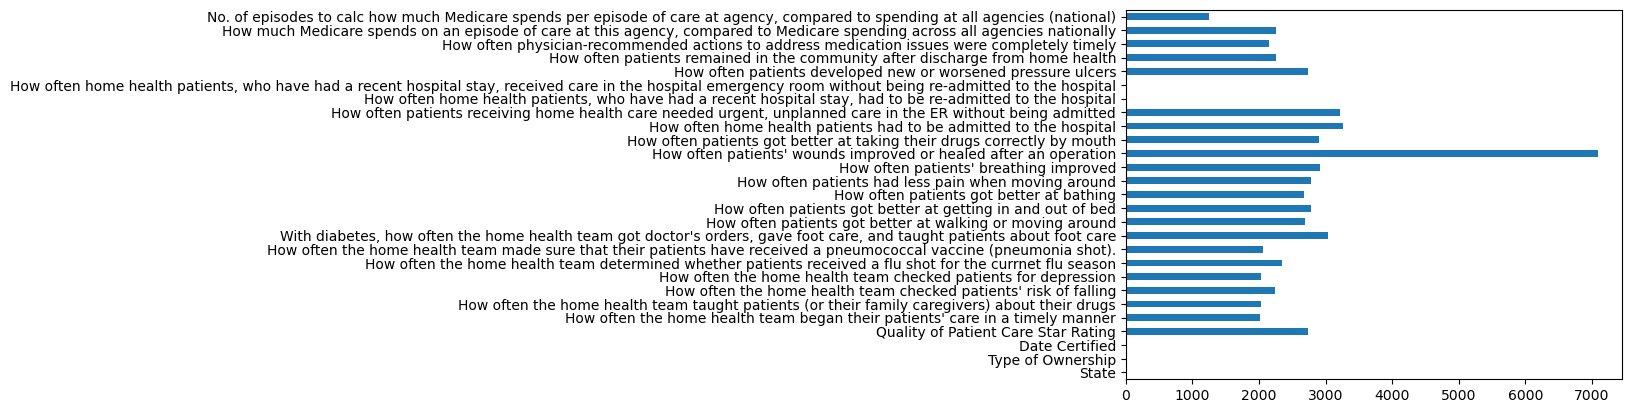

In [3]:
print(df.dropna().shape)
df.isna().sum().plot(kind='barh')
plt.show()

Three of the features are text fields starting with "worse", "same", or "better".  These will be reassigned numerical scores of -1, 0 or 1.  After further inspection the first two features had no variation and were dropped.

In [4]:
def value_assignment(txt):
    if type(txt) == str:
        a = txt.split()[0]
        lookup = {'Worse':-1, 'Same': 0, 'Better': 1, 'Not':0}
        return lookup[a]
    return 0

In [5]:
col_list = ['How often home health patients, who have had a recent hospital stay, had to be re-admitted to the hospital',
           'How often home health patients, who have had a recent hospital stay, received care in the hospital emergency room without being re-admitted to the hospital',
           'How often patients remained in the community after discharge from home health']
for col in col_list:
    df[col] = df[col].apply(value_assignment).astype(int)

In [6]:
df = df.drop(col_list[:-1], axis=1)
df.shape

(11340, 25)

Inspection of categorical features.  These three features will be compared against the cluster labels to see if the clusters are associated with states, ownership, or rating.  On visual inspection the relationship between ownership and rating might be statistically significant, but outside the scope of this project.

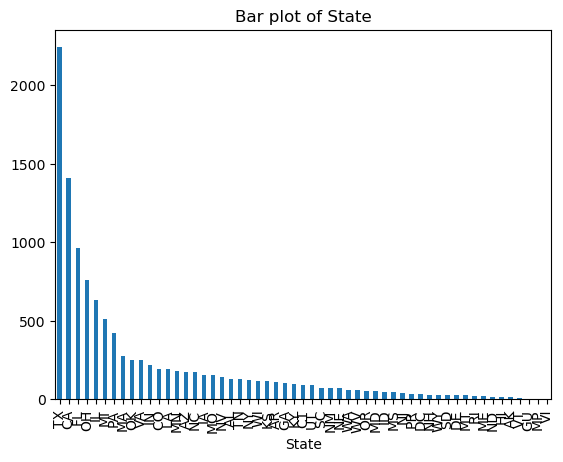

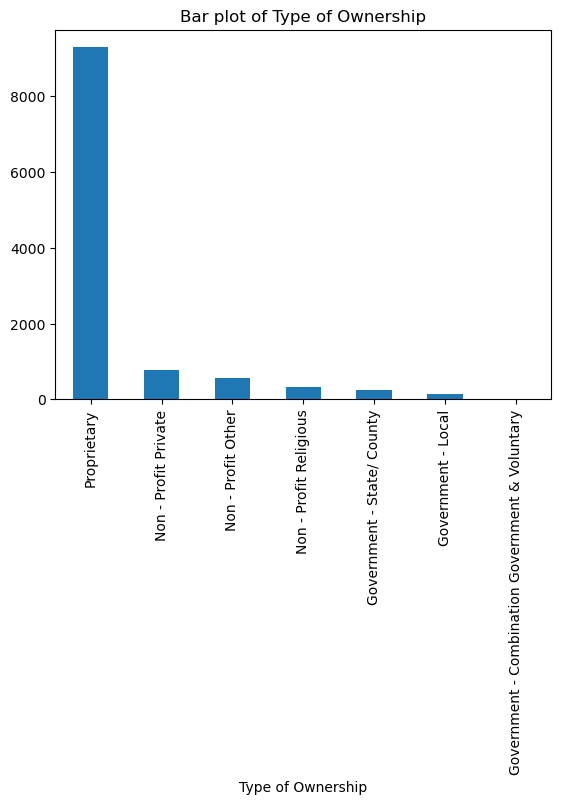

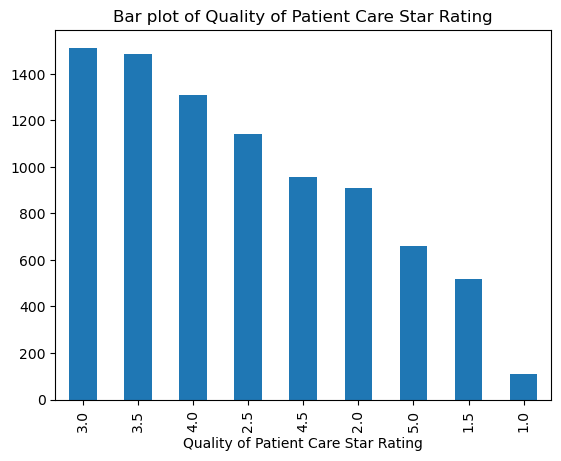

In [7]:
# named for being how the groups will be evaluated, not necessarily category type
cat_cols = ['State','Type of Ownership','Quality of Patient Care Star Rating']
for col in cat_cols:
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Bar plot of {col}')
    plt.xlabel(col)
    plt.show()

In [8]:
df.groupby('Type of Ownership')['Quality of Patient Care Star Rating'].agg([np.mean, np.std])

,mean,std
Type of Ownership,,
Government - Combination Government & Voluntary,3.076923,0.862316
Government - Local,2.889831,0.855189
Government - State/ County,2.952381,0.821435
Non - Profit Other,3.249000,0.760036
Non - Profit Private,3.190840,0.818970
Non - Profit Religious,3.388179,0.802812
Proprietary,3.291722,1.045552


For ease of viewing the data will be cut into the top 10 states and the remainder "other".  The "other" category contains 32% of the data which is larger than the ~20% in the largest state.

In [9]:
print(df.State.value_counts(normalize=True)[:10].sum())
df.State[~df.State.isin(list(df.State.value_counts().index[:10]))] = 'Other'
df.State.value_counts()

0.6802469135802469


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Other    3626
TX       2238
CA       1411
FL        960
OH        758
IL        635
MI        511
PA        425
MA        278
OK        250
VA        248
Name: State, dtype: int64

Inspecting the data we see it is pretty skewed with medians near 100, indicating mean might be a poor imputation method.

In [10]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
State,11340,11,Other,3626,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type of Ownership,11340,7,Proprietary,9291,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date Certified,11340.0,NaN,NaN,NaN,2001.073986,12.822906,1966.0,1994.0,2005.0,2011.0,2019.0
Quality of Patient Care Star Rating,8598.0,NaN,NaN,NaN,3.270935,1.002185,1.0,2.5,3.5,4.0,5.0
How often the home health team began their patients' care in a timely manner,9330.0,NaN,NaN,NaN,92.903783,8.292831,17.5,90.4,95.8,98.3,100.0
How often the home health team taught patients (or their family caregivers) about their drugs,9318.0,NaN,NaN,NaN,96.708446,7.381508,5.3,96.8,99.0,99.9,100.0
How often the home health team checked patients' risk of falling,9102.0,NaN,NaN,NaN,99.290969,2.480667,30.5,99.5,100.0,100.0,100.0
How often the home health team checked patients for depression,9305.0,NaN,NaN,NaN,96.425674,8.427544,0.0,96.6,99.0,100.0,100.0
How often the home health team determined whether patients received a flu shot for the currnet flu season,8996.0,NaN,NaN,NaN,73.45697,19.106062,0.0,66.2,78.1,86.0,100.0
How often the home health team made sure that their patients have received a pneumococcal vaccine (pneumonia shot).,9286.0,NaN,NaN,NaN,76.191374,21.016171,0.0,69.5,82.65,90.3,100.0


The data was split into X containing numerical features, and y containing categorical features.  The numerical features will be clustered and reviewed to see if the clusters align with any categorical features.  The data was further split into training and test sets.  The data was split in case any supervised learning will be done in the future.

In [11]:
X,y = df.drop(cat_cols, axis=1), df[cat_cols]
X.shape, y.shape

((11340, 22), (11340, 3))

In [12]:
X_train = X.sample(frac=0.8, replace=False, random_state=251, axis=0)
X_test = X.drop(X_train.index)
y_test = y.drop(X_train.index)
y_train = y.drop(y_test.index)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9072, 22), (2268, 22), (9072, 3), (2268, 3))

Histograms of the data show a severe left skew on many features.  Due to this median imputation will be done for the  missing data.

In [13]:
def plot_hists(df, drop=None):
    for col in df.columns.drop(drop):
        df[col].hist()
        plt.title(col)
        plt.show()

In [14]:
#plot_hists(X_train,drop=['State', 'Type of Ownership'])

The data cleaning and transformation pipeline first imputes missing data using the column median and then transforms the data using a min-max scaler.

In [15]:
#encoder = OneHotEncoder(drop=None, handle_unknown='ignore', sparse=False)
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = MinMaxScaler()
#text_transformer = ColumnTransformer([('text', encoder, ['State'])], remainder = 'passthrough')
pipe = Pipeline(steps=[('imputer', imputer), ('scaler', scaler)])

In [16]:
X_train_transformed = pd.DataFrame(pipe.fit_transform(X_train), columns=X_train.columns)
print(X_train_transformed.shape)
X_train_transformed.describe(include='all').transpose()

(9072, 22)


,count,mean,std,min,25%,50%,75%,max
Date Certified,9072.0,0.662276,0.242034,0.0,0.528302,0.735849,0.849057,1.0
How often the home health team began their patients' care in a timely manner,9072.0,0.919487,0.093571,0.0,0.903030,0.949091,0.974545,1.0
How often the home health team taught patients (or their family caregivers) about their drugs,9072.0,0.969135,0.072789,0.0,0.973601,0.989440,0.996832,1.0
How often the home health team checked patients' risk of falling,9072.0,0.991951,0.031424,0.0,0.995683,1.000000,1.000000,1.0
How often the home health team checked patients for depression,9072.0,0.968556,0.078902,0.0,0.974000,0.990000,0.998000,1.0
How often the home health team determined whether patients received a flu shot for the currnet flu season,9072.0,0.745244,0.170142,0.0,0.703000,0.782000,0.839250,1.0
How often the home health team made sure that their patients have received a pneumococcal vaccine (pneumonia shot).,9072.0,0.774436,0.191539,0.0,0.738000,0.828000,0.886000,1.0
"With diabetes, how often the home health team got doctor's orders, gave foot care, and taught patients about foot care",9072.0,0.974564,0.062653,0.0,0.978791,0.991516,1.000000,1.0
How often patients got better at walking or moving around,9072.0,0.727315,0.117455,0.0,0.687564,0.741044,0.784033,1.0
How often patients got better at getting in and out of bed,9072.0,0.715347,0.125155,0.0,0.673156,0.734631,0.778689,1.0


The correlation matrix heatmap shows significant cross correlation in areas, for example if the agency made sure the patient got a flu shot they would also get a pneumococcal vaccine.  Another cluster of correlations occurs with patient movement.

In [17]:
X_train_transformed.corr().style.background_gradient()

,Date Certified,How often the home health team began their patients' care in a timely manner,How often the home health team taught patients (or their family caregivers) about their drugs,How often the home health team checked patients' risk of falling,How often the home health team checked patients for depression,How often the home health team determined whether patients received a flu shot for the currnet flu season,How often the home health team made sure that their patients have received a pneumococcal vaccine (pneumonia shot).,"With diabetes, how often the home health team got doctor's orders, gave foot care, and taught patients about foot care",How often patients got better at walking or moving around,How often patients got better at getting in and out of bed,How often patients got better at bathing,How often patients had less pain when moving around,How often patients' breathing improved,How often patients' wounds improved or healed after an operation,How often patients got better at taking their drugs correctly by mouth,How often home health patients had to be admitted to the hospital,"How often patients receiving home health care needed urgent, unplanned care in the ER without being admitted",How often patients developed new or worsened pressure ulcers,How often patients remained in the community after discharge from home health,How often physician-recommended actions to address medication issues were completely timely,"How much Medicare spends on an episode of care at this agency, compared to Medicare spending across all agencies nationally","No. of episodes to calc how much Medicare spends per episode of care at agency, compared to spending at all agencies (national)"
Date Certified,1.000000,-0.057909,-0.047767,-0.001650,-0.022280,-0.084596,-0.145099,0.047840,-0.056737,-0.105886,-0.066906,-0.003339,-0.101922,0.072007,-0.088880,-0.124774,-0.162018,-0.033831,-0.210731,-0.039460,-0.074835,-0.312967
How often the home health team began their patients' care in a timely manner,-0.057909,1.000000,0.238729,0.190218,0.230435,0.256739,0.262298,0.158222,0.280767,0.227662,0.284633,0.265876,0.233726,0.025445,0.228882,0.057062,0.006476,-0.061076,0.147374,0.198196,0.101500,0.098996
How often the home health team taught patients (or their family caregivers) about their drugs,-0.047767,0.238729,1.000000,0.236231,0.262389,0.246836,0.242879,0.280531,0.149822,0.113987,0.169393,0.164084,0.130856,0.004841,0.122137,0.032140,0.008657,-0.027680,0.097541,0.355027,0.053298,0.092477
How often the home health team checked patients' risk of falling,-0.001650,0.190218,0.236231,1.000000,0.298287,0.167776,0.162960,0.211005,0.120733,0.106332,0.140532,0.096968,0.083397,-0.000301,0.117066,-0.010449,-0.011003,-0.026317,0.059205,0.156572,0.010627,0.045280
How often the home health team checked patients for depression,-0.022280,0.230435,0.262389,0.298287,1.000000,0.180304,0.189195,0.163670,0.135436,0.120064,0.145096,0.147804,0.115865,-0.013066,0.103895,-0.006159,-0.005424,-0.020508,0.080335,0.192295,0.018950,0.044874
How often the home health team determined whether patients received a flu shot for the currnet flu season,-0.084596,0.256739,0.246836,0.167776,0.180304,1.000000,0.725965,0.151853,0.257960,0.301492,0.305524,0.242440,0.304122,0.017387,0.282381,0.076695,0.072665,-0.031424,0.180189,0.232392,0.126494,0.111773
How often the home health team made sure that their patients have received a pneumococcal vaccine (pneumonia shot).,-0.145099,0.262298,0.242879,0.162960,0.189195,0.725965,1.000000,0.123821,0.192387,0.260628,0.246862,0.149166,0.246145,0.001378,0.240317,0.089841,0.123720,-0.011445,0.122805,0.275957,0.146984,0.094431
"With diabetes, how often the home health team got doctor's orders, gave foot care, and taught patients about foot care",0.047840,0.158222,0.280531,0.211005,0.163670,0.151853,0.123821,1.000000,0.130005,0.097366,0.135837,0.159620,0.100538,0.026550,0.106590,0.008464,-0.031169,-0.053288,0.027219,0.210702,-0.003257,0.037262
How often pa

### Modeling
Agglomerative clustering, kmeans clustering, and non-negative matrix factorization were trained on the dataset.  Agglomerative clustering found two distinct clusters, or possibly around 7 smaller clusters.  Kmeans found 2 clusters, and nmf found 3 clusters.  Silhouette score was used as the evaluation metric between models.  Silhouette score is the mean intra-cluster distance vs the mean nearest cluster distance, and ranges from -1 (poor clustering) to 1 (excellent clustering).

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [18]:
#copied from sklearn
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

The agglomerative clustering dendrogram shows two significant clusters and maybe around 7 small clusters.

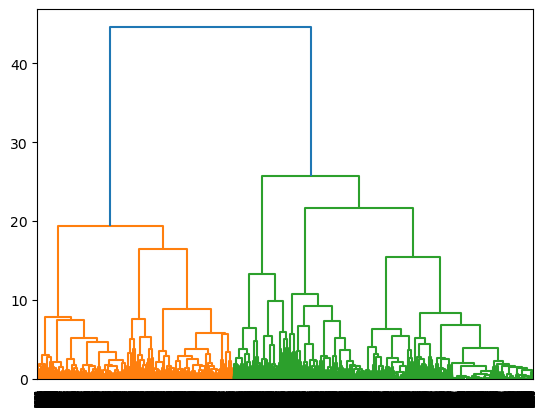

In [19]:
# takes forever to run
cluster = AgglomerativeClustering(n_clusters=1, compute_distances=True)
cluster.fit(X_train_transformed)
plot_dendrogram(cluster)
plt.show()

Kmeans clustering had the best score with two clusters (silhouette score closer to 1 is better).

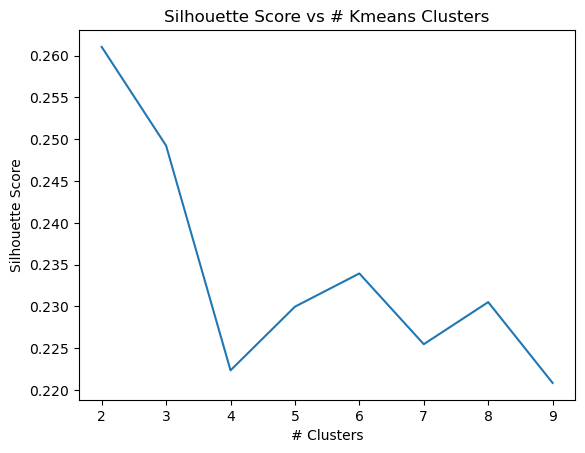

In [20]:
silhouette_scores = []
for n in range(2,10):
    labels = KMeans(n_clusters=n, random_state=42).fit(X_train_transformed).labels_
    silhouette_scores.append(silhouette_score(X_train_transformed, labels))
plt.plot(range(2,10), silhouette_scores)
plt.title('Silhouette Score vs # Kmeans Clusters')
plt.xlabel('# Clusters')
plt.ylabel('Silhouette Score')
plt.show()

NMF had the best performance with 3 components but on further inspection only two were significant.

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: Fu

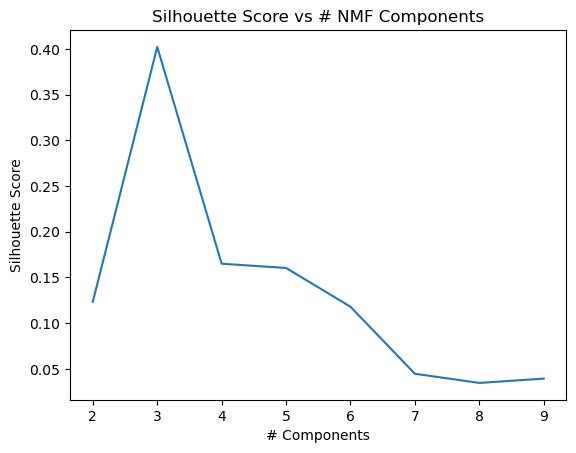

In [21]:
silhouette_scores = []
for n in range(2,10):
    labels = np.argmax(NMF(n_components=n, max_iter=400).fit_transform(X_train_transformed), axis=1)
    silhouette_scores.append(silhouette_score(X_train_transformed, labels))
plt.plot(range(2,10), silhouette_scores)
plt.title('Silhouette Score vs # NMF Components')
plt.xlabel('# Components')
plt.ylabel('Silhouette Score')
plt.show()

In [22]:
#final model suite
agg_cluster = AgglomerativeClustering(n_clusters=2, compute_distances=False).fit(X_train_transformed).labels_
kmn = KMeans(n_clusters=2, random_state=42).fit(X_train_transformed).labels_
nmf = np.argmax(NMF(n_components=3, max_iter=400).fit_transform(X_train_transformed), axis=1)
model_list = [agg_cluster, kmn, nmf]
model_labels = ['Agg Cluster','KMN','NMF']

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  ConvergenceWarning,


Comparing the best agglomerative, kmeans, and nmf models found nmf performed the best.

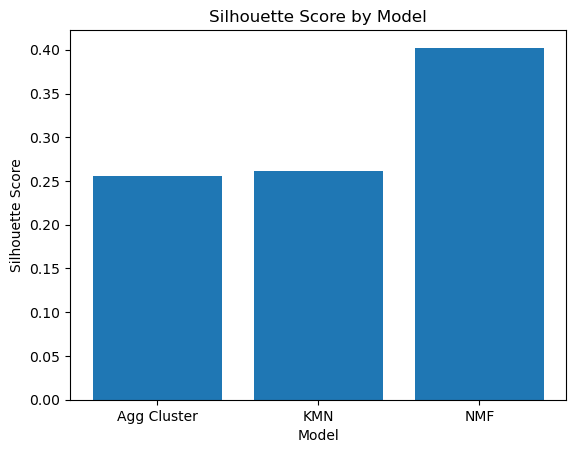

In [23]:
scores = []
for model in model_list:
    scores.append(silhouette_score(X_train_transformed, model))
plt.bar(model_labels, scores)
plt.title('Silhouette Score by Model')
plt.xlabel('Model')
plt.ylabel('Silhouette Score')
plt.show()

In [24]:
for key, data in zip(model_labels, model_list):
    y_train[key] = data

In [25]:
y_train.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
State,9072,11,Other,2900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type of Ownership,9072,7,Proprietary,7441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quality of Patient Care Star Rating,6907.0,NaN,NaN,NaN,3.267265,1.010202,1.0,2.5,3.5,4.0,5.0
Agg Cluster,9072.0,NaN,NaN,NaN,0.395392,0.488962,0.0,0.0,0.0,1.0,1.0
KMN,9072.0,NaN,NaN,NaN,0.393408,0.488533,0.0,0.0,0.0,1.0,1.0
NMF,9072.0,NaN,NaN,NaN,0.048501,0.307668,0.0,0.0,0.0,0.0,2.0


The categorical features were analyzed by model to see how the features were separated.  Only two nmf clusters show despite three components since one components was not significant.  None of the categorical features have a relationship with the clusters.

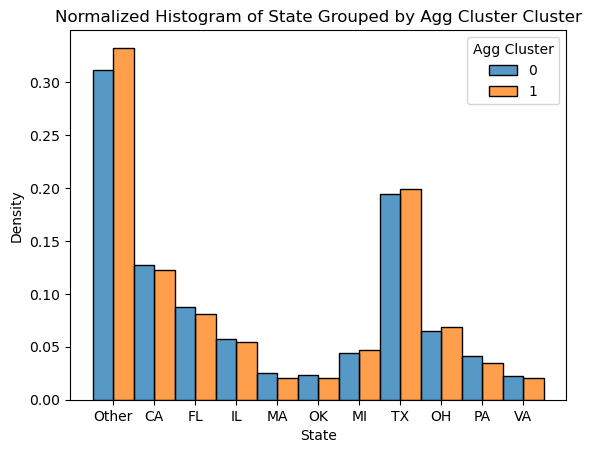

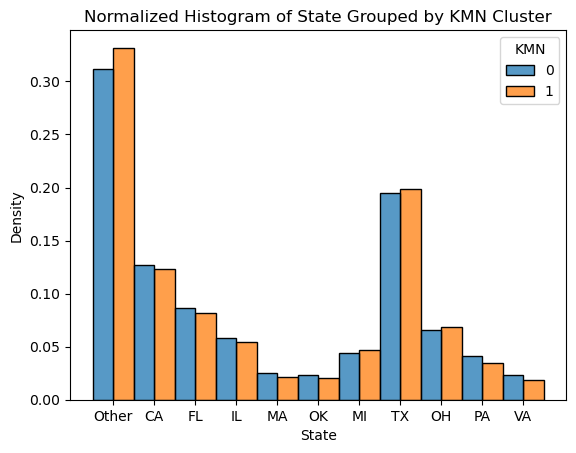

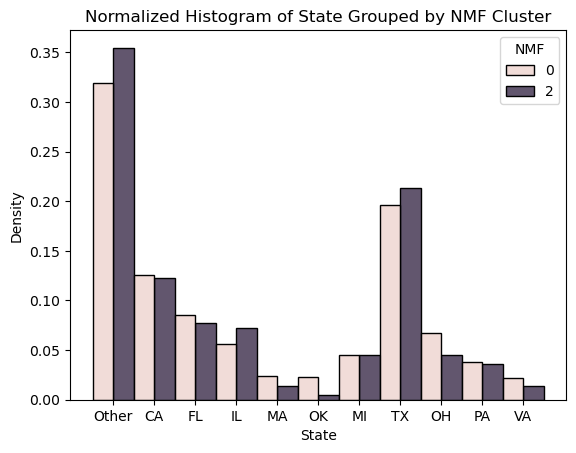

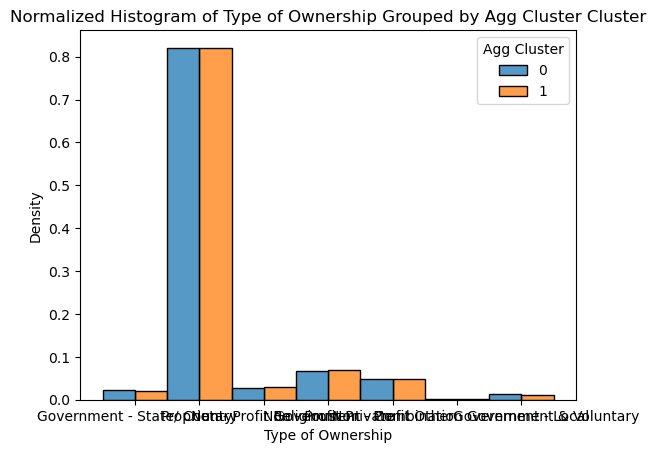

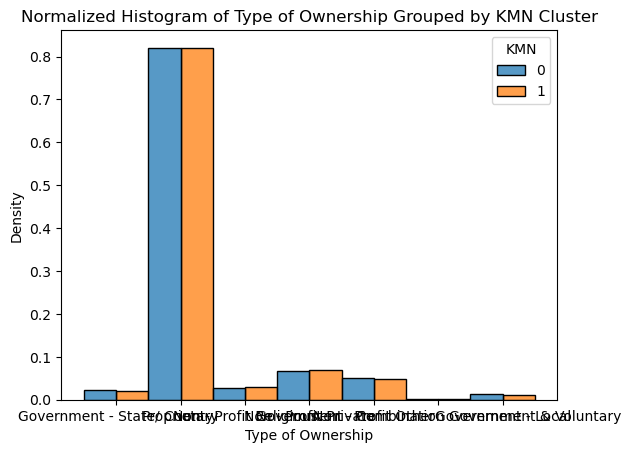

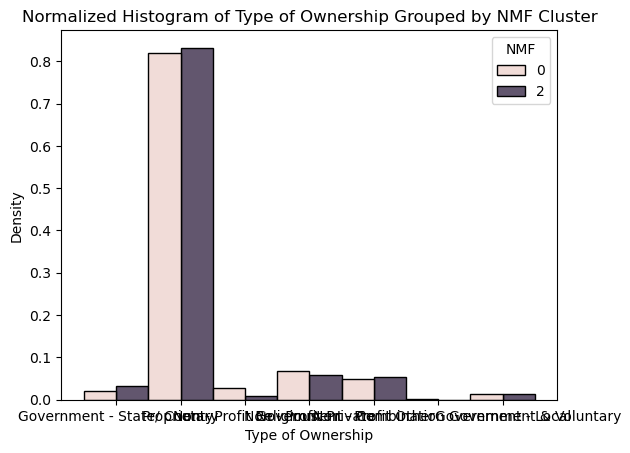

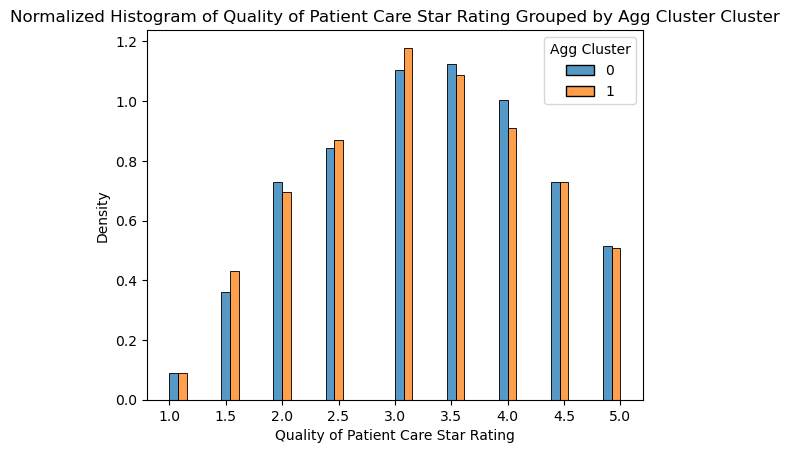

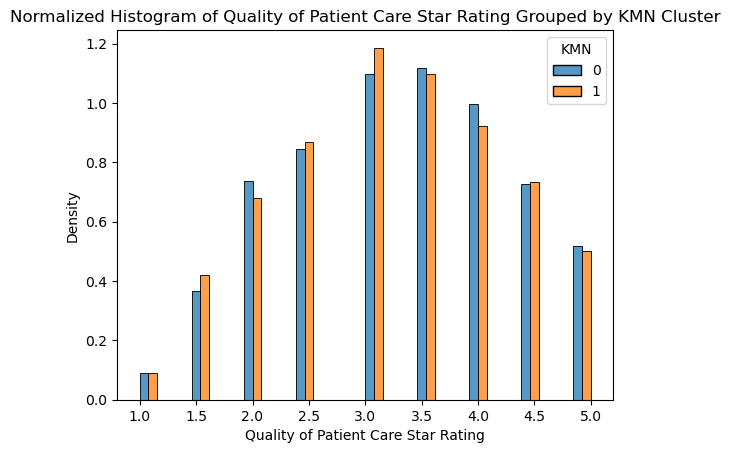

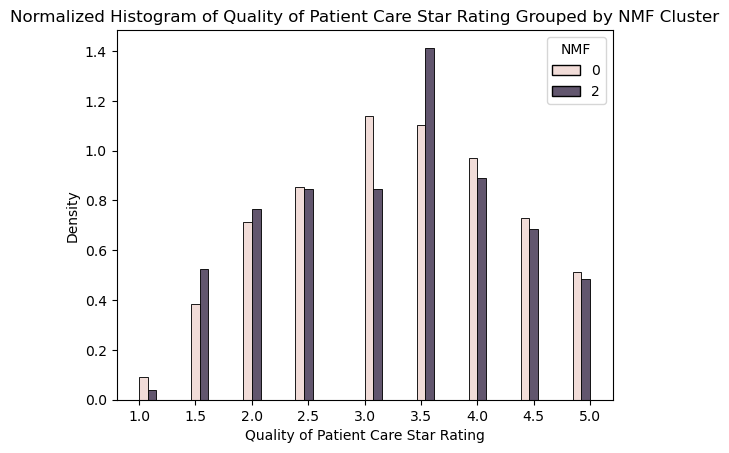

In [26]:
for col in cat_cols:
    for model in model_labels:
        sns.histplot(data=y_train, x=col, hue=model, stat='density', common_norm=False, multiple='dodge')
        plt.title(f'Normalized Histogram of {col} Grouped by {model} Cluster')
        plt.show()

The numerical features were reviewed by model.  NMF cluster 2 shows a clear preference for newer agencies that offered fewer services and patients were less likely to be admitted to the hospital indicating the patients required less support.  Cluster 0 made more medical decisions, were more likely to need medical assistance, and showed more improvement with agency.

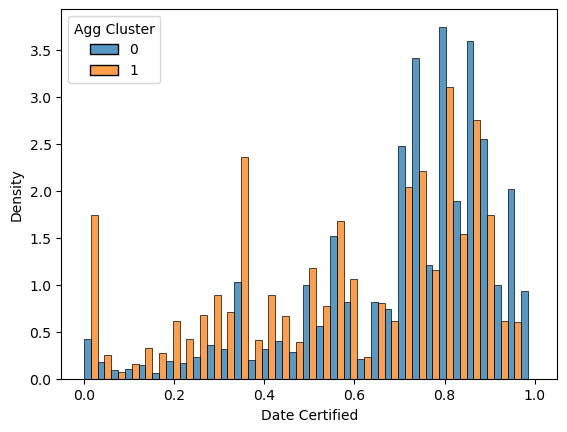

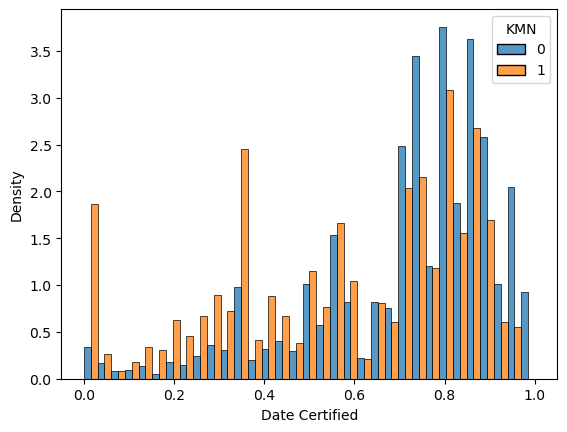

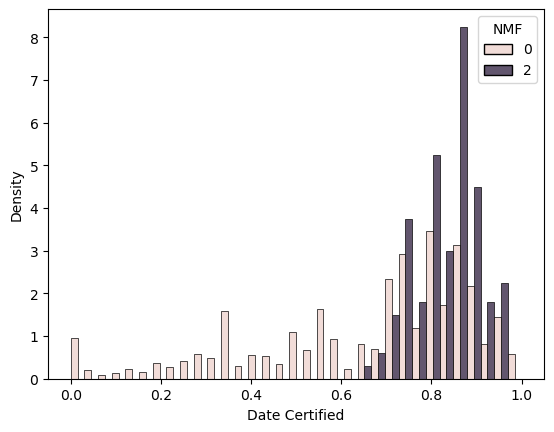

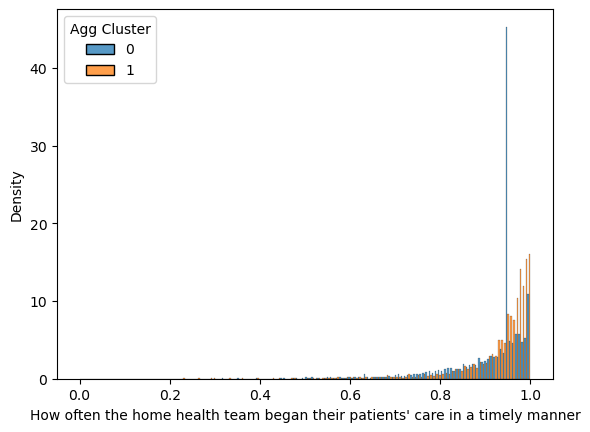

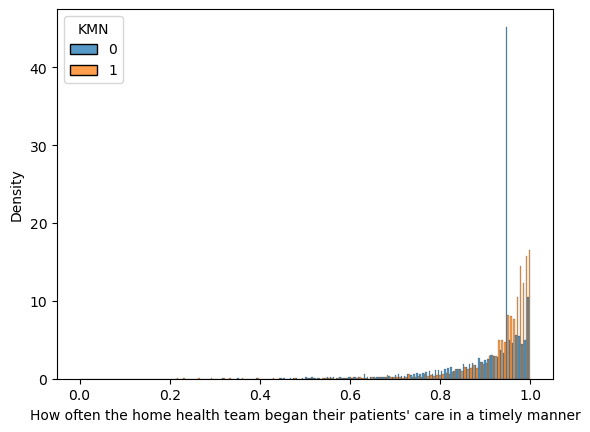

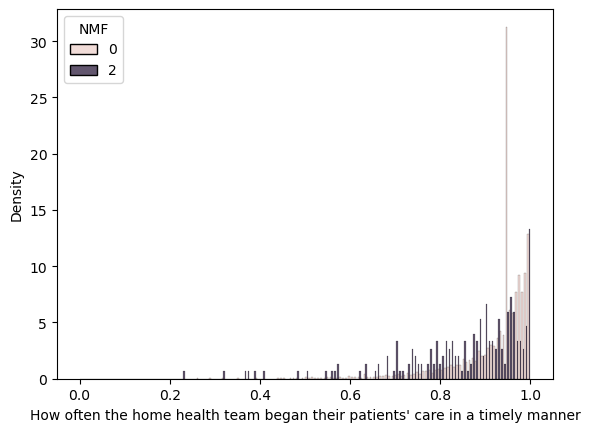

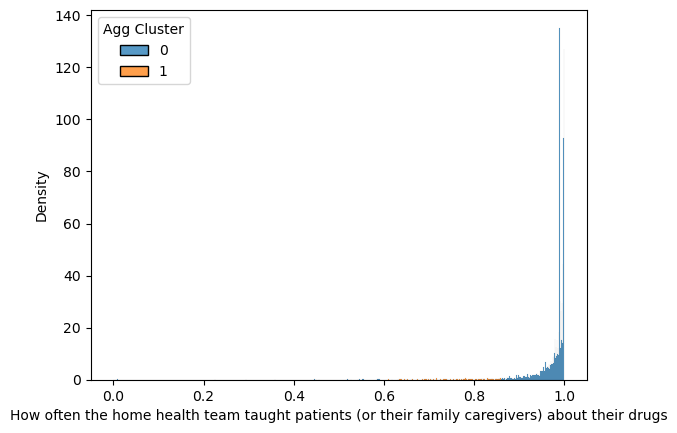

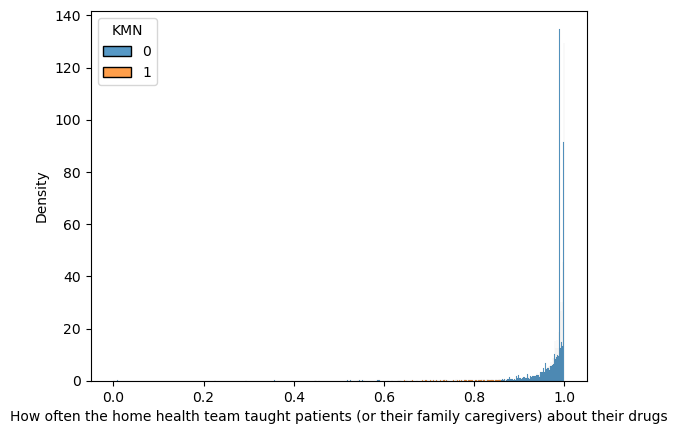

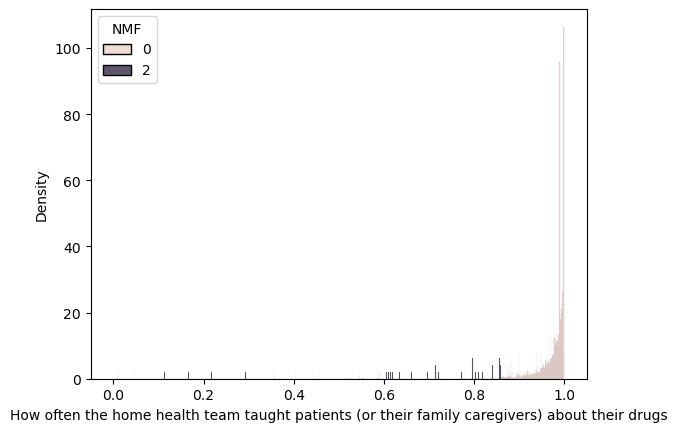

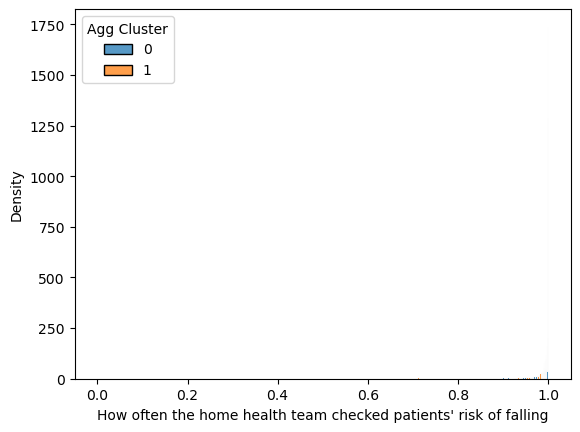

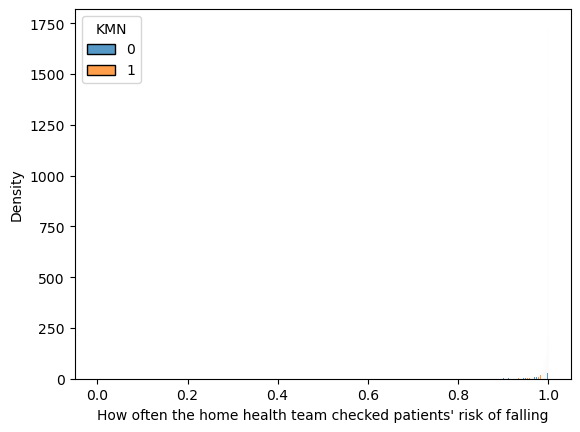

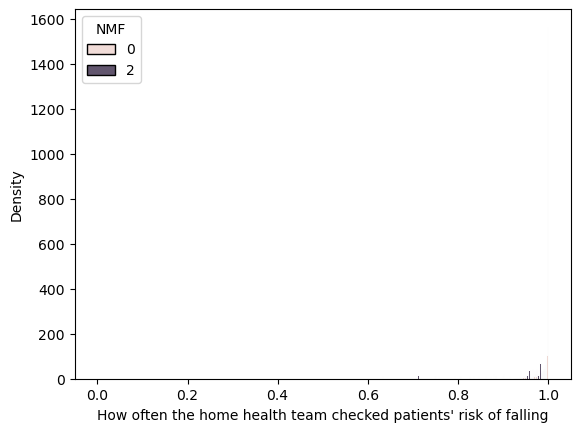

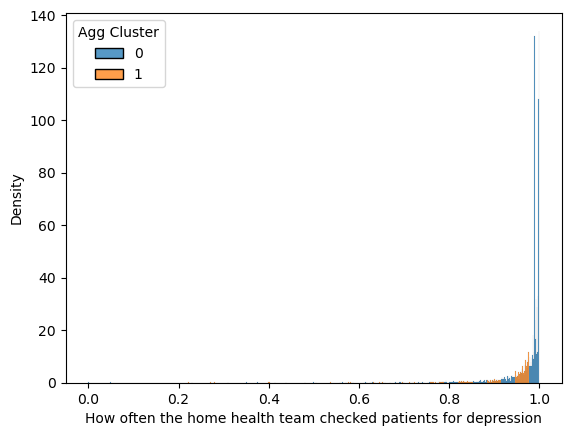

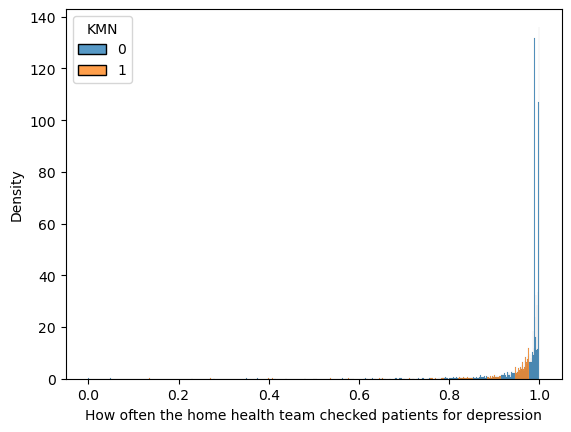

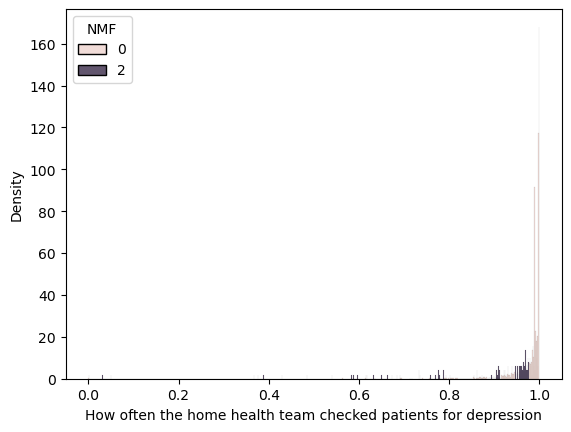

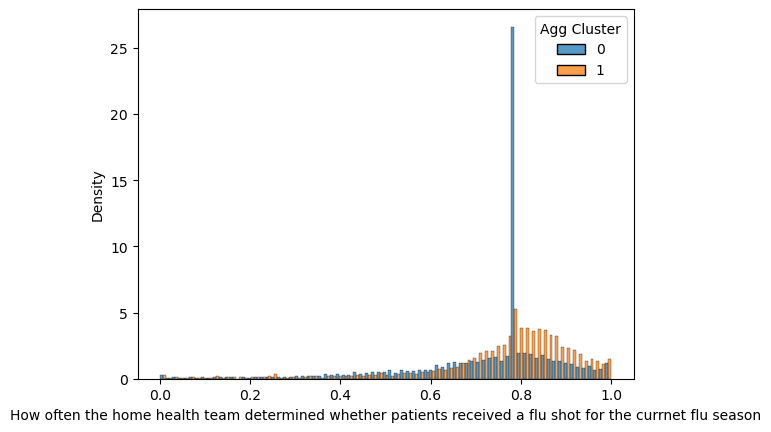

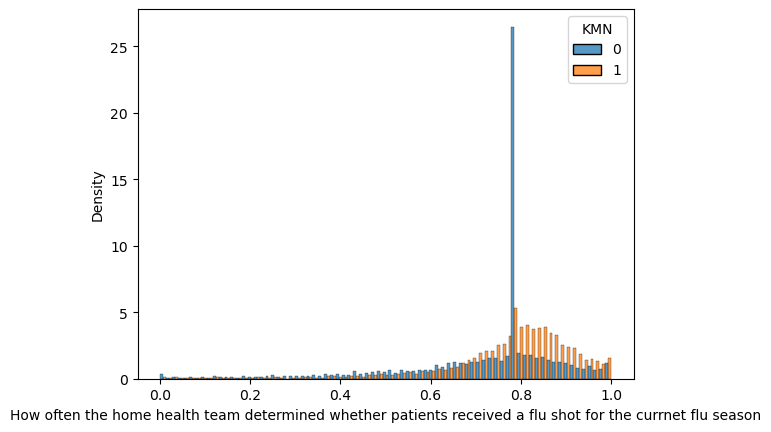

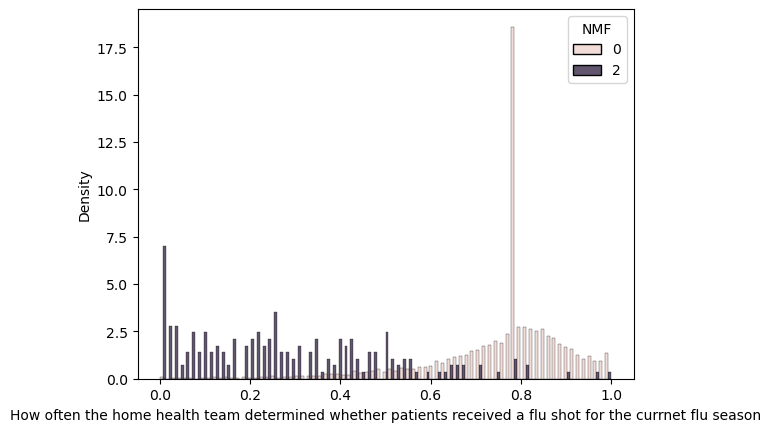

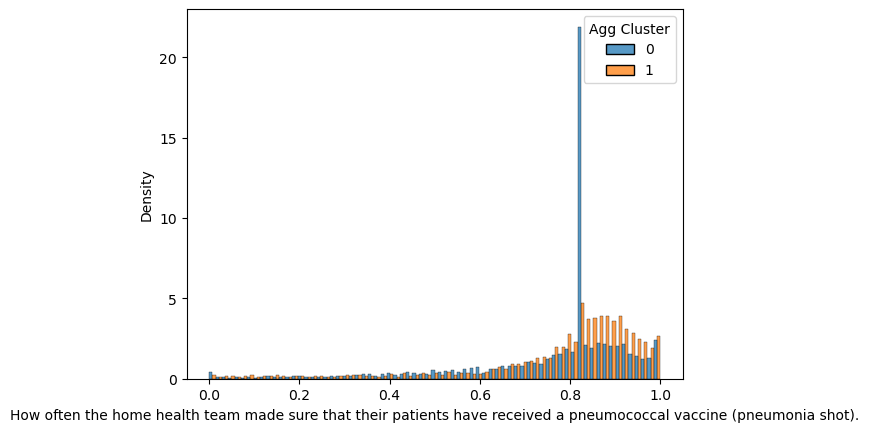

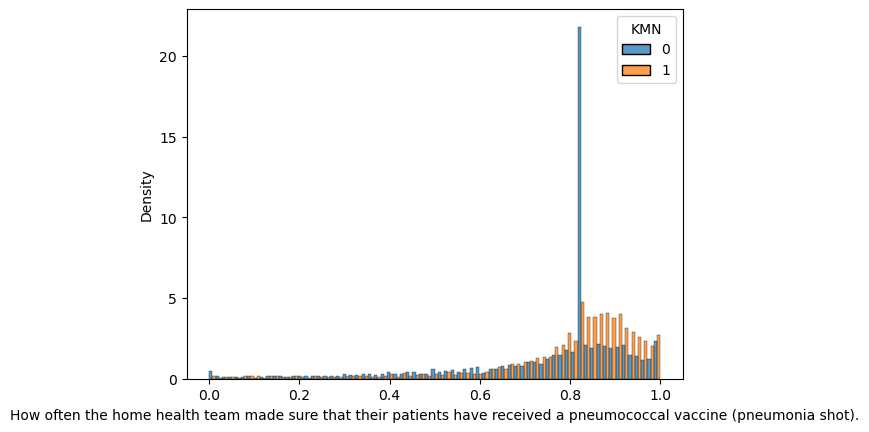

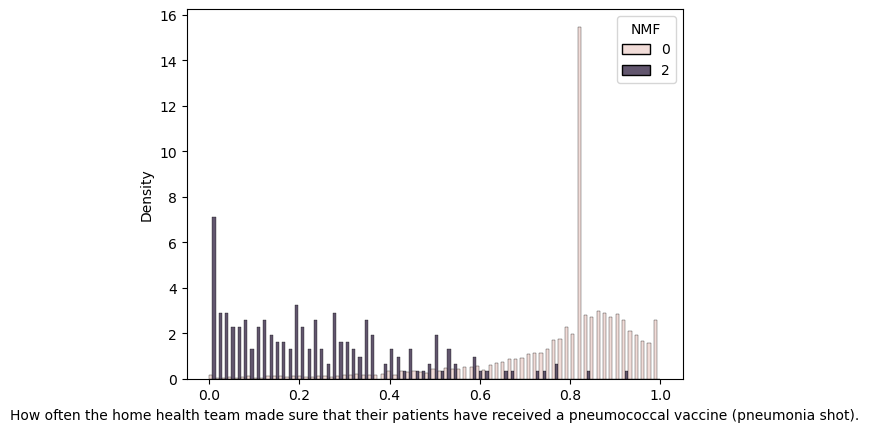

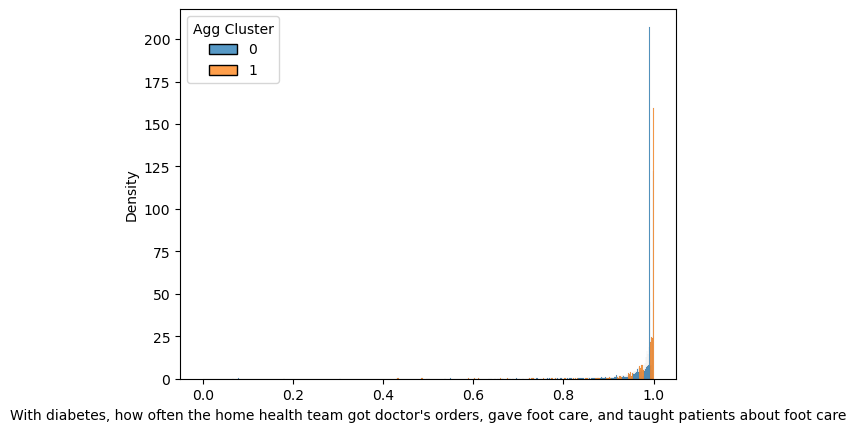

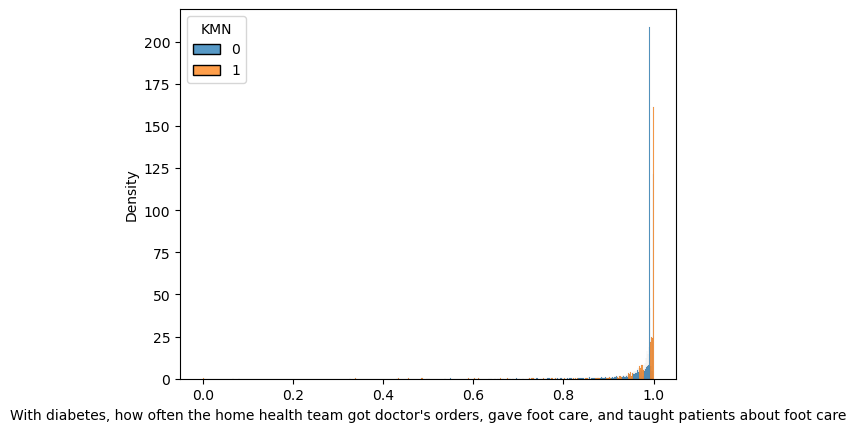

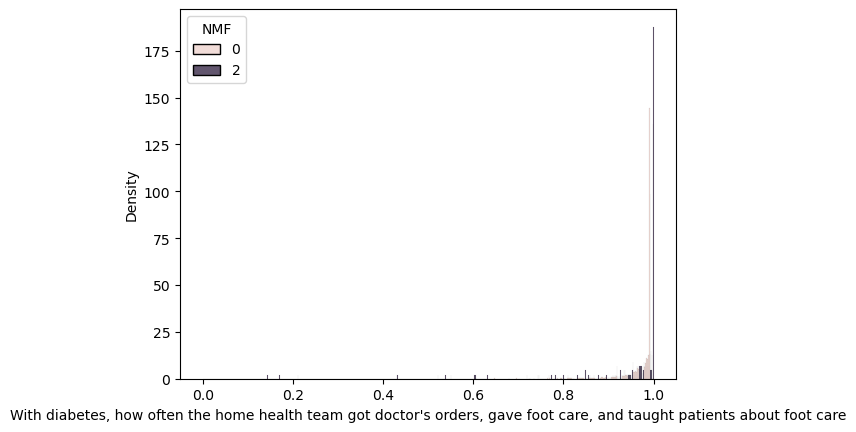

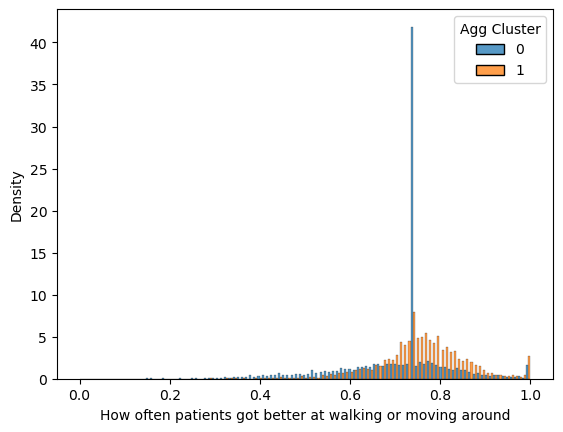

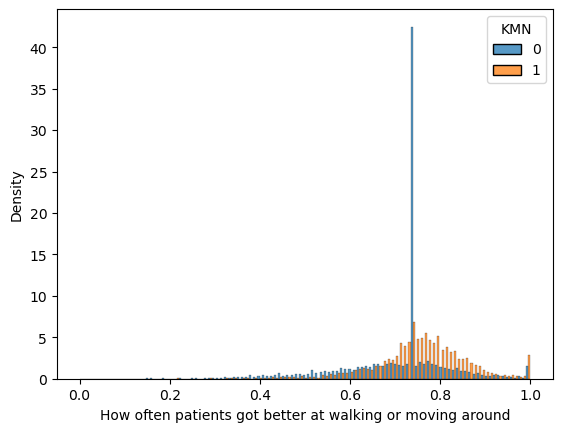

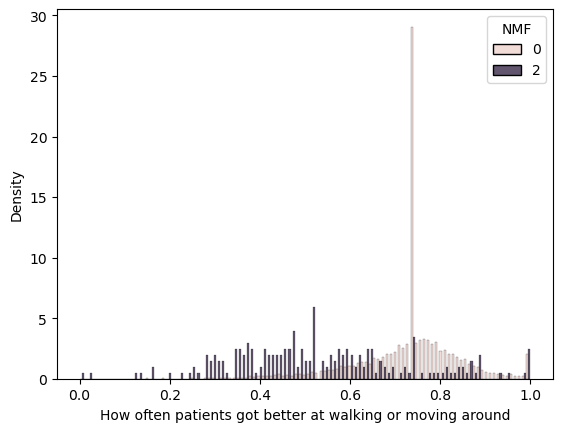

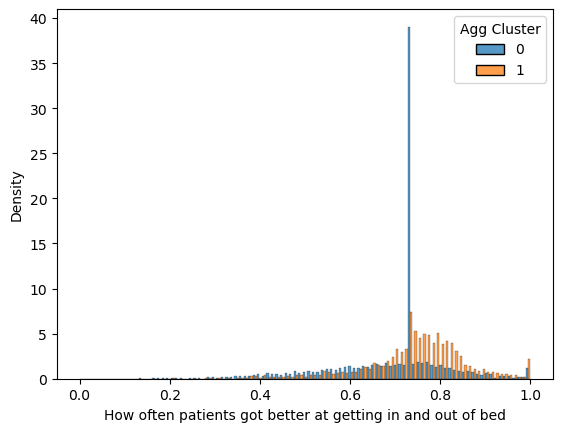

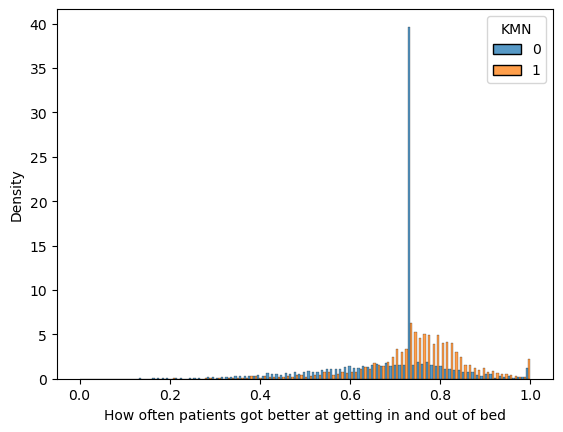

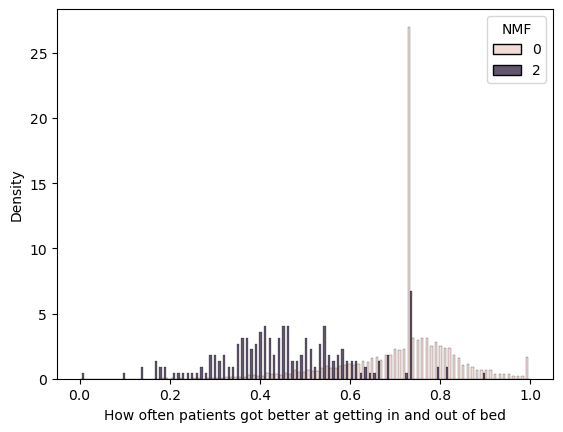

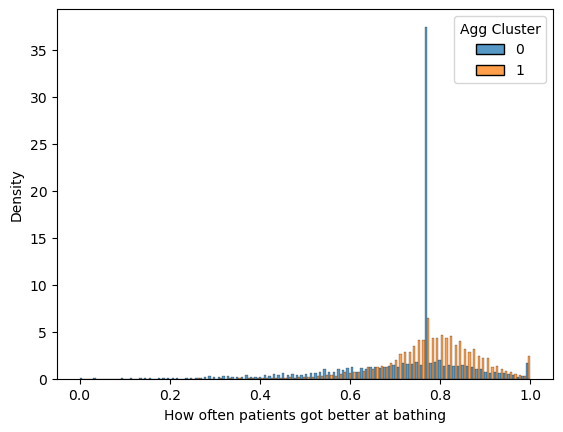

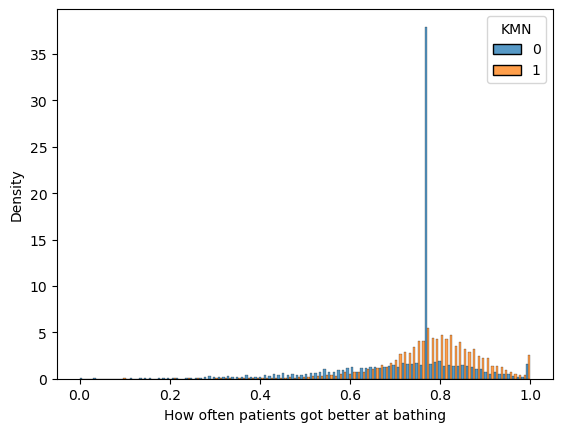

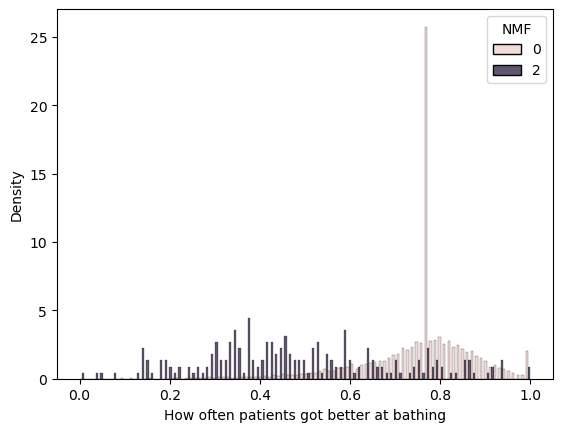

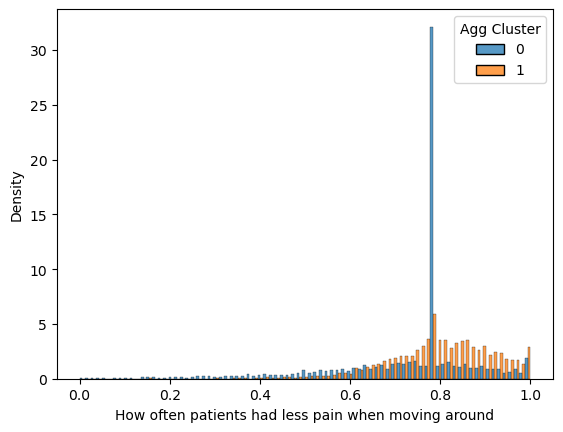

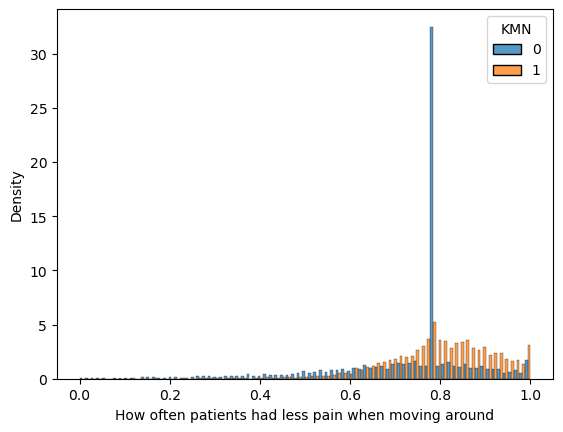

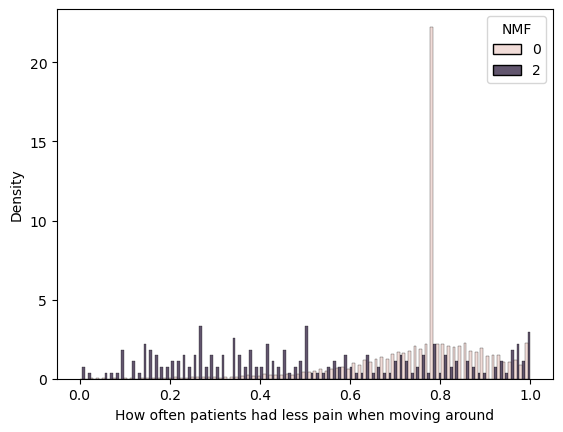

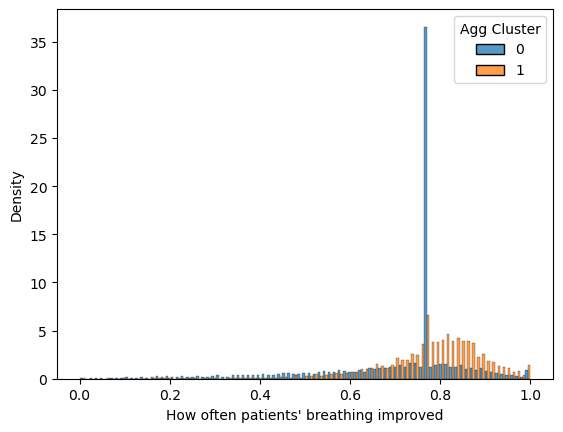

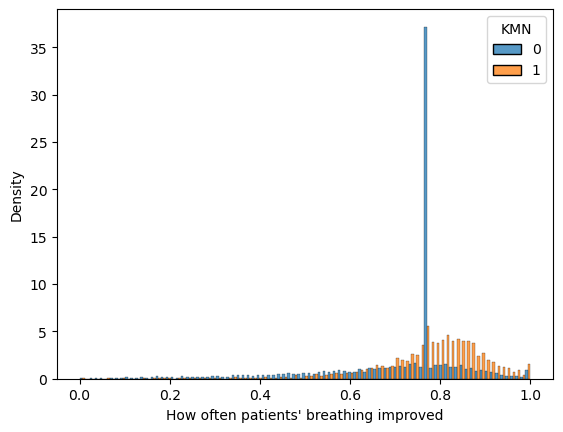

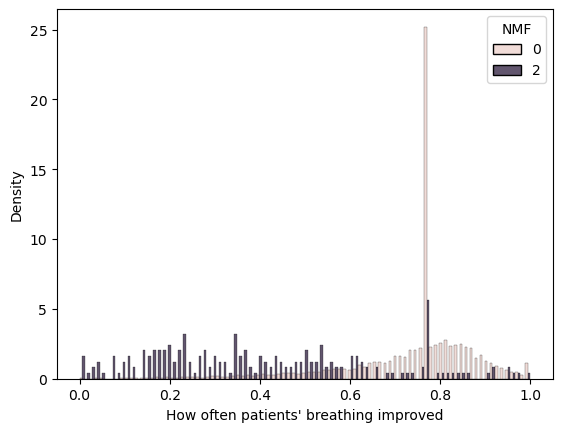

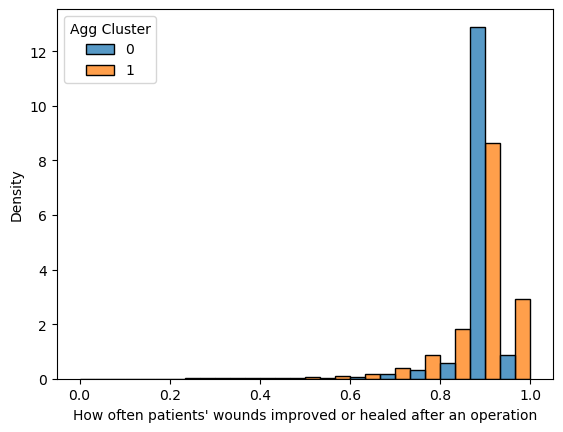

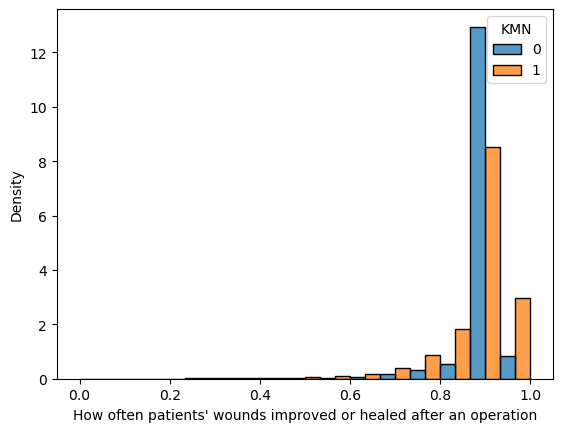

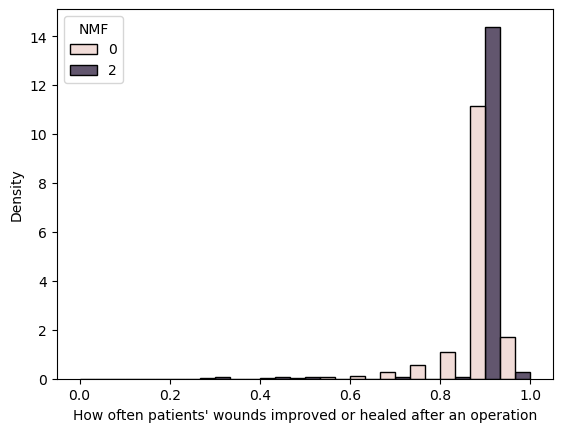

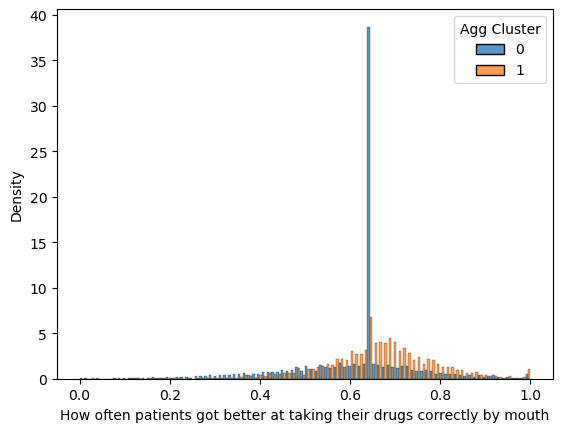

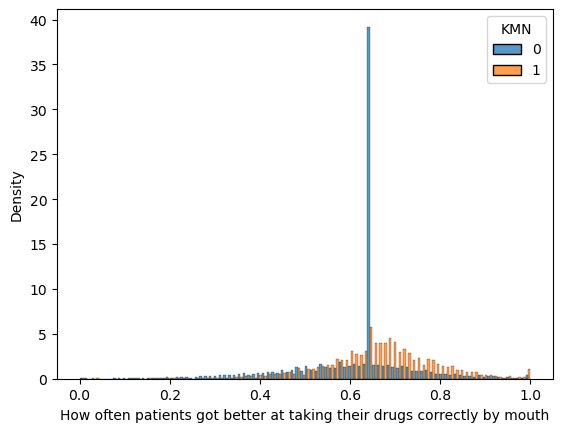

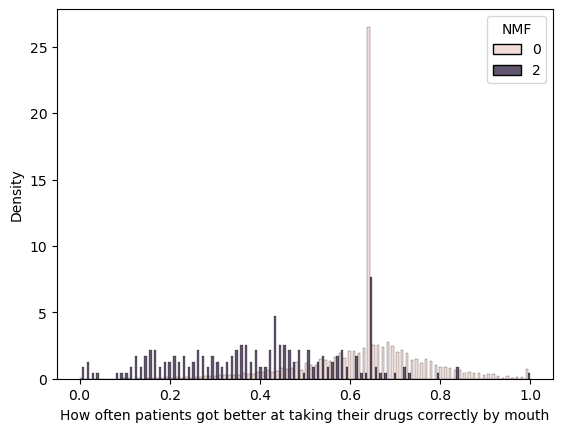

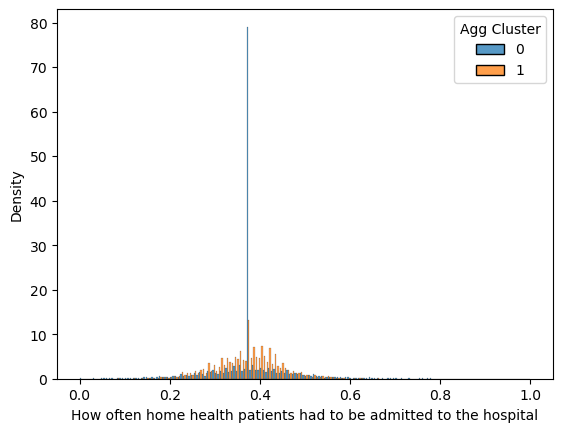

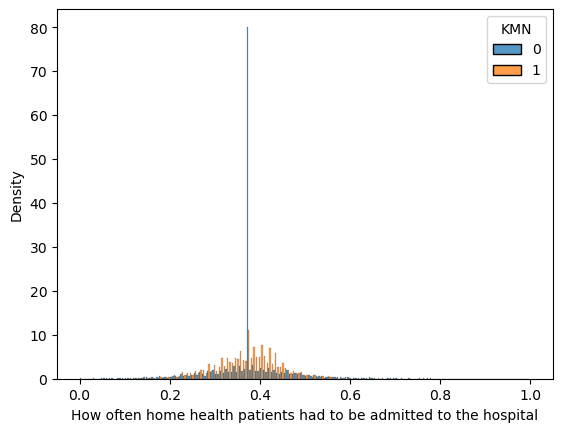

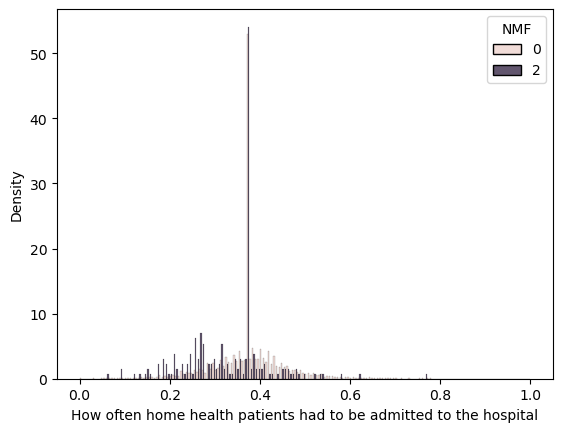

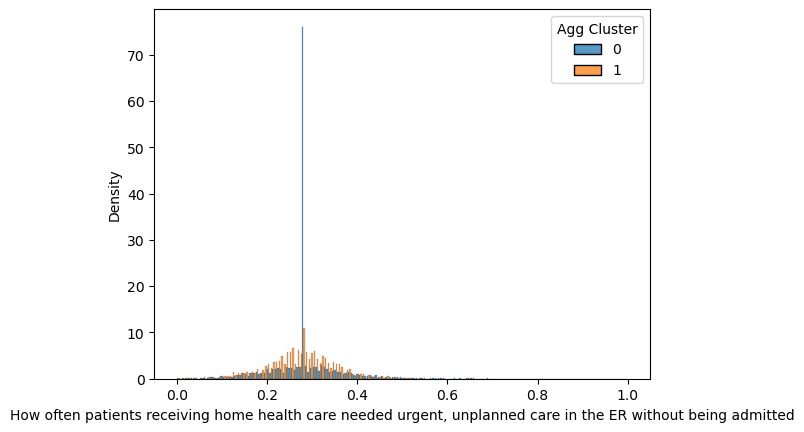

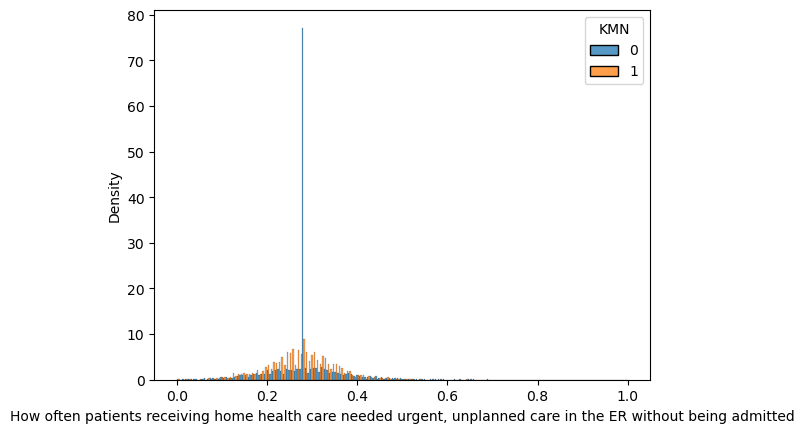

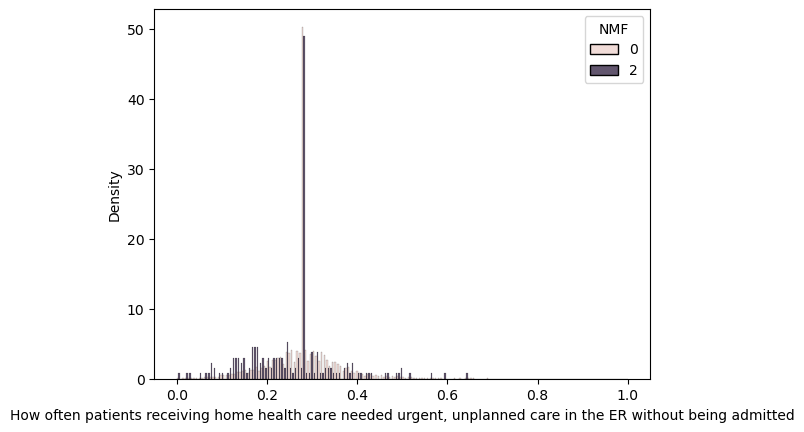

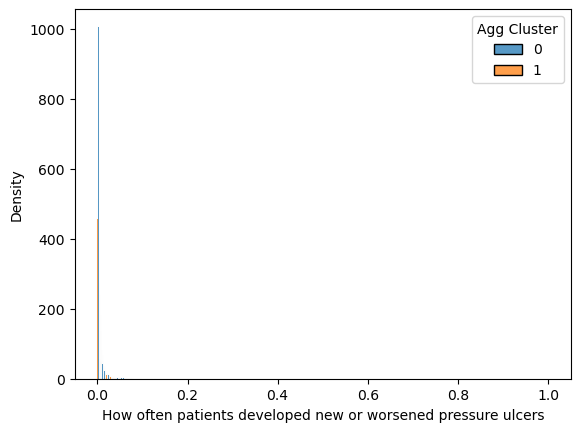

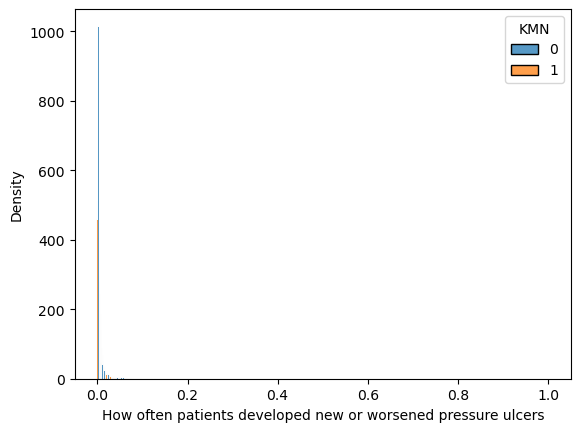

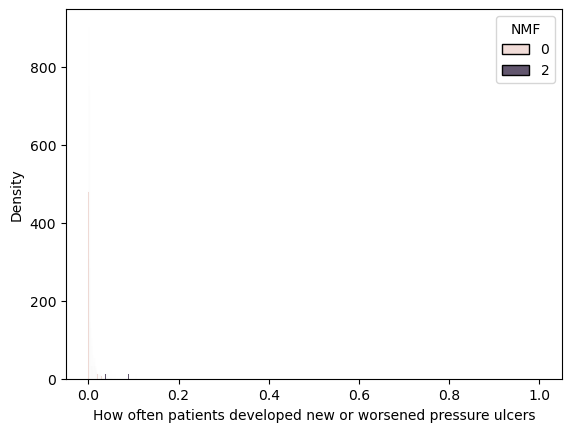

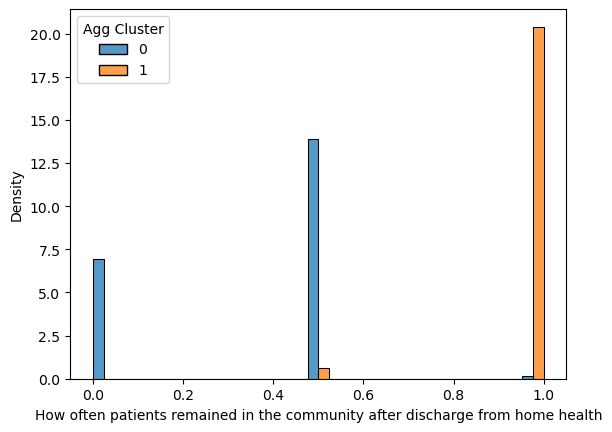

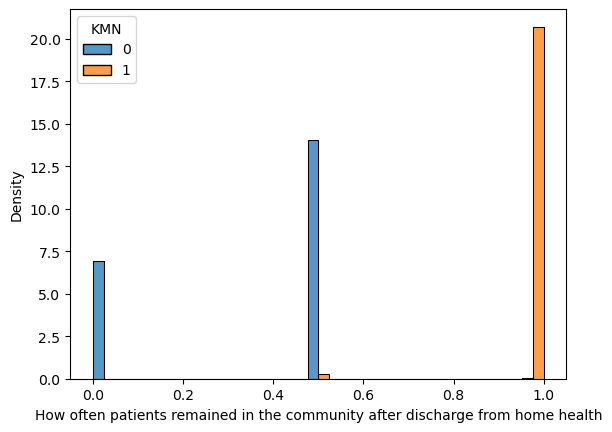

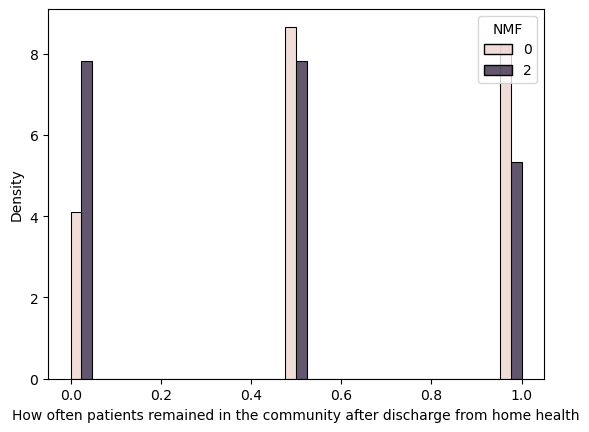

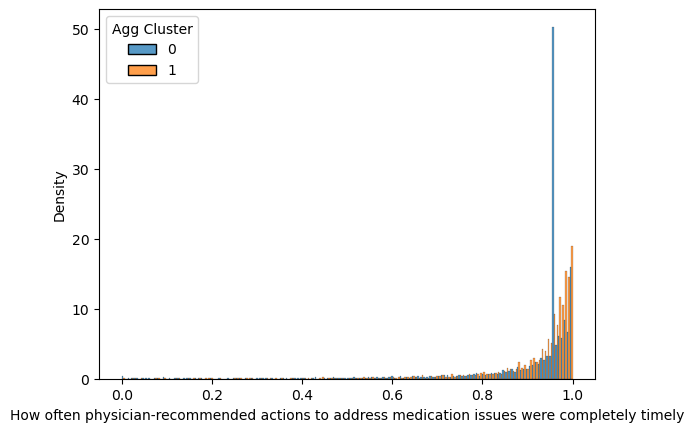

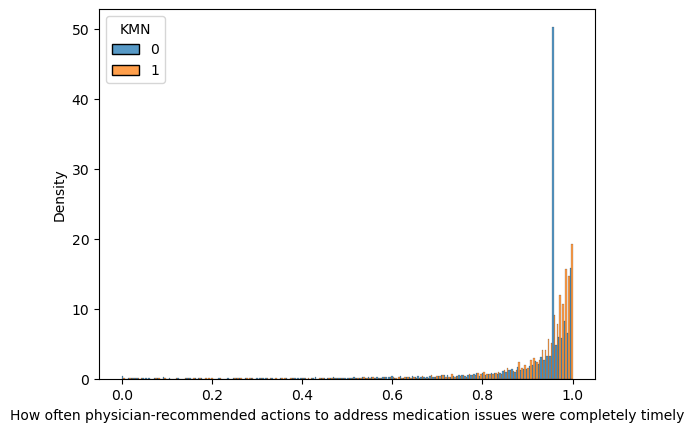

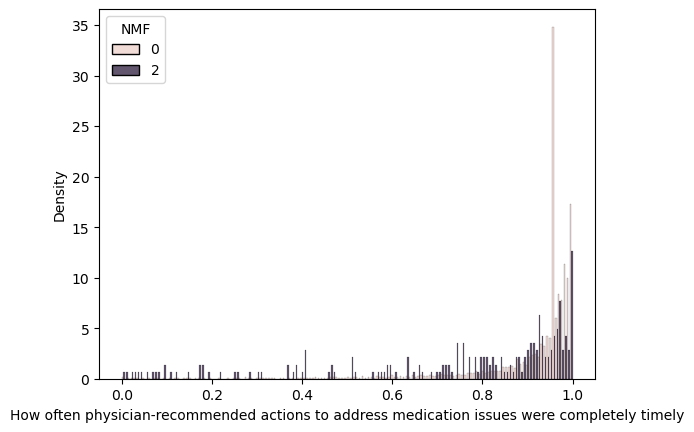

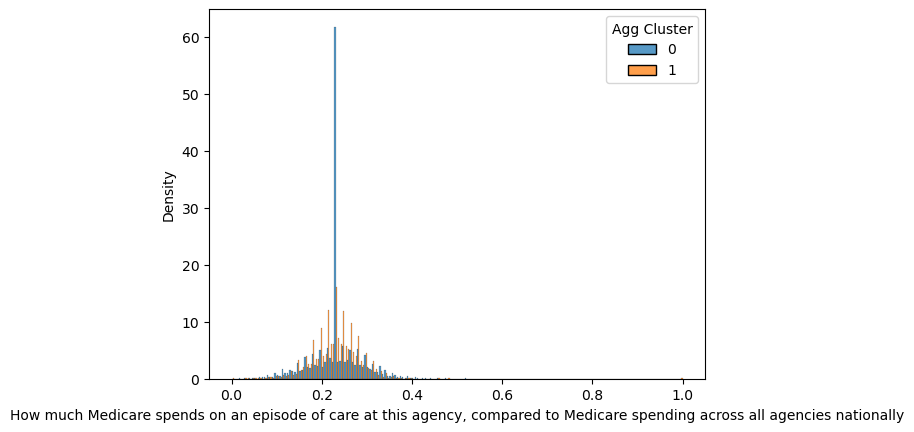

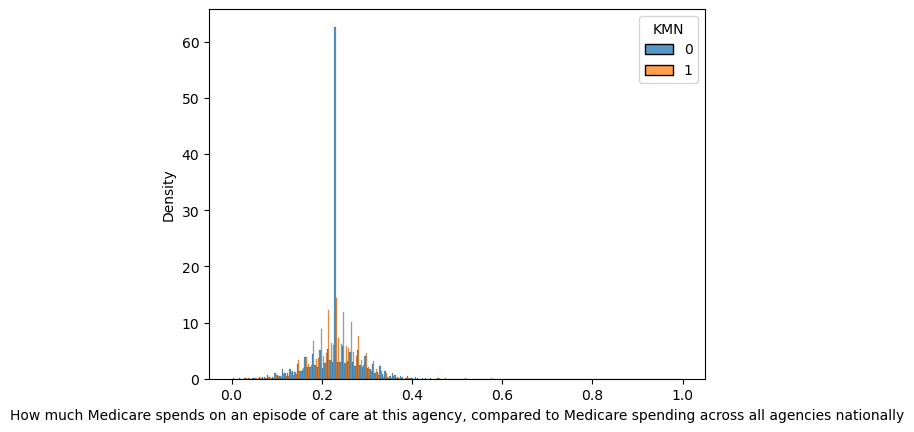

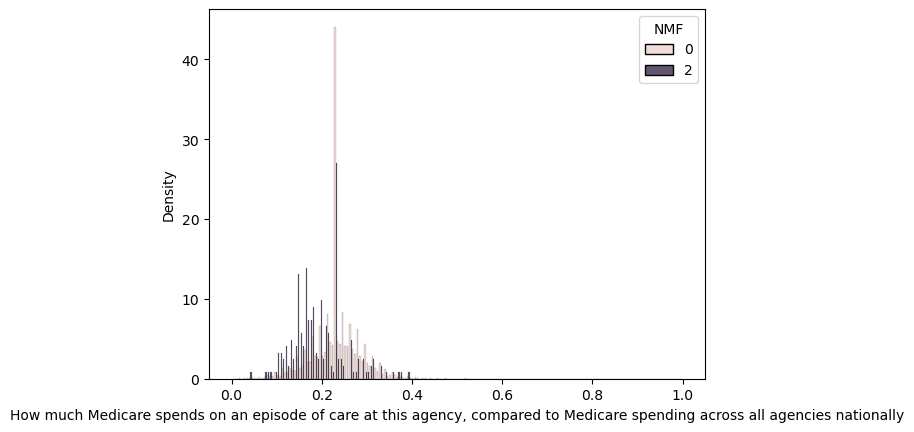

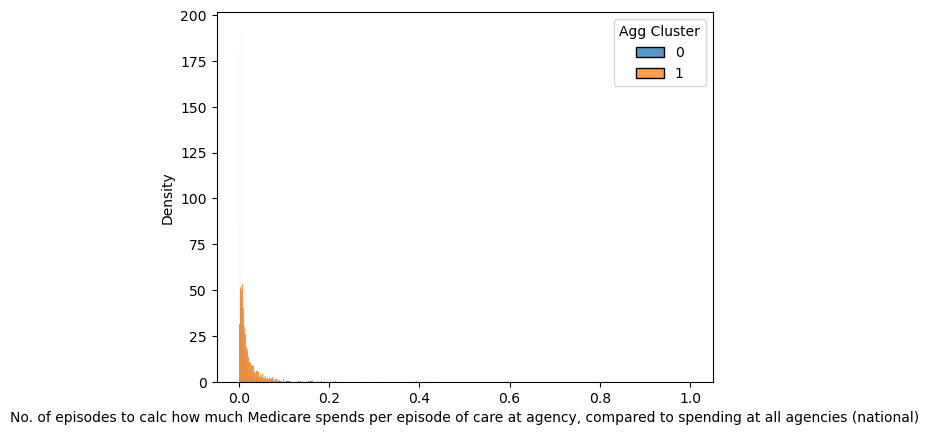

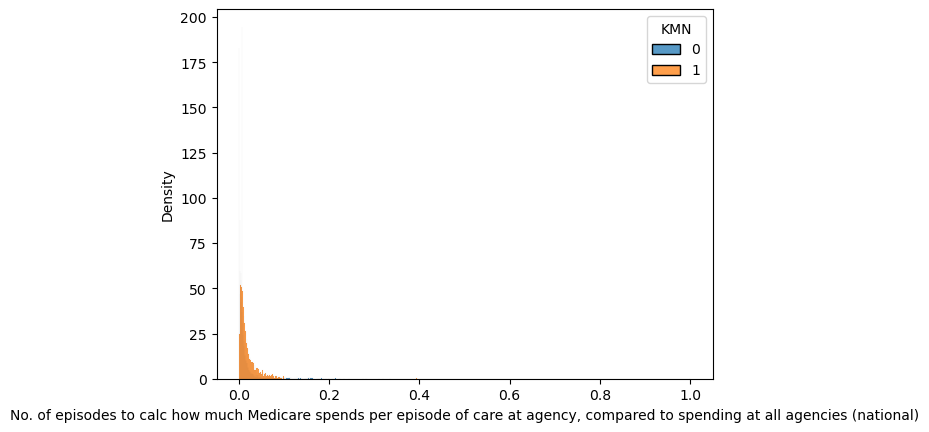

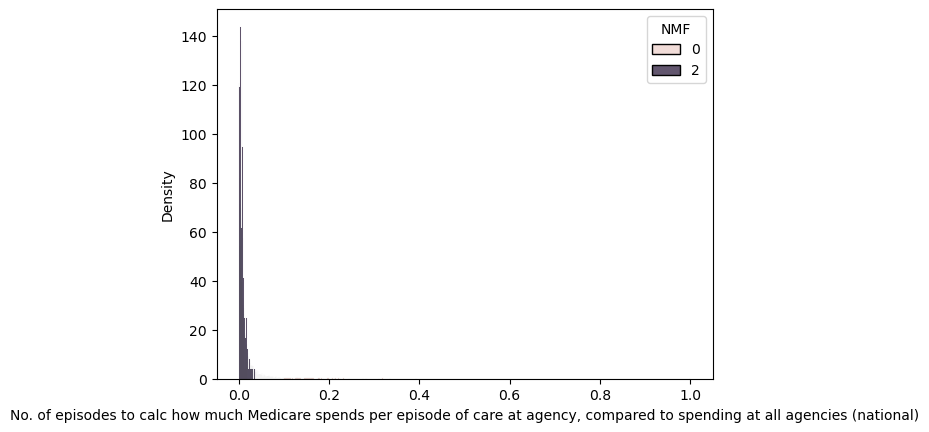

In [27]:
X_analysis = X_train_transformed.copy()
for key, data in zip(model_labels, model_list):
    X_analysis[key] = data
for col in X_train_transformed.columns:
    for model in model_labels:
        sns.histplot(data=X_analysis, x=col, hue=model, stat='density', common_norm=False, multiple='dodge')
        plt.show()